### Importando as Imagens

Agora iremos de fato classificar as faces com o dataset que processamos do George Tech a partir do arquivo que salvamos com *pickle* chamado *people_faces.pkl*.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

Abre o arquivo .pkl com as imagens e labels.

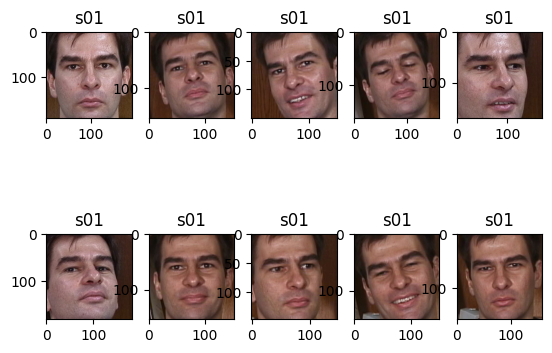

In [2]:
with open('people_faces.pkl', 'rb') as f: # rb (read binary) irá ler o arquivo caso exista
    images, labels = pickle.load(f)

# Mostra as 10 primeiras faces
for index in range(0,10):
    plt.subplot(2,5, index+1)

    plt.imshow(images[index])
    plt.title(labels[index])

### Pré processamento (Redimensionando as imagens e escala de cinza)

**As imagens estão com dimensões diferentes** (é possível observar verificando as dimensões de cada imagem, por exemplo, images[0].shape), portanto, deveremos **normalizar essas imagens**, isto é, **torna-las todas com a mesma dimensão**.

Assim como, também é necessário transformar as imagem em escala de cinza para não ter 3 dimensões (3 canais de cores RGB).

Isto é necessário pois, modelos de Machine Learning ou Redes Neuras necessitam de imagens com as mesmas dimensões e em escala de cinza para realizar as predições de forma mais eficiente e rápida.

**O parâmetro interpolation (interpolação)**
- Este parâmetro é um algorítmo que é utilizado em casos da imagem ser menor que o valor que irá ser redimensionado.
- Ao redimensionar, não irá distorcer a imagem.

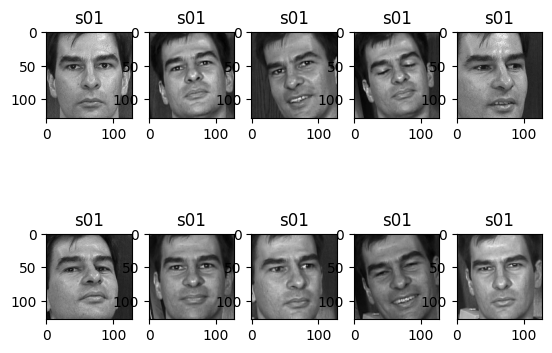

In [3]:
images_gray_and_resized = []

for img in images:
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # Transforma a imagem em escala de cinza
    new_img = cv2.resize(new_img, (128,128), # Redimensiona a imagem para 128x128 pixels
                         interpolation=cv2.INTER_LANCZOS4) # Para não distorcer a imagem em caso de ser menor
     
    images_gray_and_resized.append(new_img) # Adiciona a imagem processada no array

# Transformando em arrays numpy para ser mais rápido o processamento
'''
Só o fato de conseguirmos converter um array nativo para array numpy, significa que todas as dimensões das imagens estão padronizadas em 128x128 pixels
Do contrário, haveria um erro de array não homogêneo, pois as listas numpy precisam ter dimensões iguais
'''
images_gray_and_resized = np.array(images_gray_and_resized)

# Mostra as 10 primeiras faces
for index in range(0,10):
    plt.subplot(2,5, index+1)

    plt.imshow(images_gray_and_resized[index], cmap='gray')
    plt.title(labels[index])

**Realizando codificação dos labels com LabelEncoder**

In [4]:
le = LabelEncoder()

# Transformará cada classe string em um número inteiro
labels = le.fit_transform(labels)

### Separando dos dados em treino e teste

O stratify serve para fazermos a divisão dos dados entre treino e teste de forma *estratificada*, isto é, para que a quantidade de imagens de treino e testes tenham a mesma proporção.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images_gray_and_resized, labels, 
                                                    test_size=0.4, 
                                                    random_state=42, 
                                                    stratify=labels) # Realizando a separação de forma estratificada

**Verificando a quantidade de imagens utilizadas para treino e teste**

Aqui apenas estamos verificando se o conjunto de treino e teste estão bem distribuidas.

É possível observar que o conjunto de treino e teste para cada classe não atinge o número de 15 exemplos, isto é pelo fato de que não foi possível detectar a face no rosto, talvez pelo rosto da pessoa na foto não estar posicionado de forma frontal para a camêra.

In [6]:
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

df_train_test = pd.DataFrame({
    'train_count': y_train_series.value_counts(),
    'test_count': y_test_series.value_counts()
})

df_train_test

,train_count,test_count
0,9,6
1,9,6
2,9,6
3,8,6
4,4,2
5,8,5
6,9,6
7,9,6
8,9,6
9,6,4


**Função para facilitar o teste e avaliação do modelo**

In [7]:
def test_model(model, x_test_data, y_test_data):
    model_predicts = []
    for test in x_test_data:
        predict = model.predict(test)
        model_predicts.append(predict)
        
    # Transforma o array de predicts em array numpy para realizar indexação
    model_predicts = np.array(model_predicts)

    y_model_predicts = model_predicts[:, 0] # Todas as linhas, primeira coluna
    model_distance = model_predicts[:, 1] # Todas as linhas, segunda coluna

    print('Exemplo de retorno do predict do primeiro item de teste:')
    print('Classe prevista:', model_predicts[0][0])
    print('Distância:', model_predicts[0][1])
    print(classification_report(y_true=y_test_data, y_pred=y_model_predicts))

### Classificador Eigenfaces

É uma técnica que usa matemática para reduzir a complexidade de imagens de rostos e reconhecer padrões importantes. O objetivo é transformar imagens de rostos em algo que o computador consiga comparar facilmente, mantendo só as informações importantes e descartando os detalhes que não ajudam no reconhecimento.

**Calculado a média dos rostos**
- Uma das etapas é calcular o "rosto médio". É tirado a média de cada pixel entre todas as imagens, isso nos dá uma imagem genérica que representa a média de todos os rostos.
    - Isto é importante para focar nos detalhes que fazem os rostos se diferenciarem entre si, onde precisamos subtrair o "rosto médio" de todas as imagens. Isso remove as partes que são parecidas entre todos os rostos.

**Análise de Componentes Principais (PCA)**
- Essa técnica descobre os padrões mais importantes nos dados, ou seja, as características que mais variam entre os rostos.
    - Esses padrões são chamados de **EigenFaces**. Cada Eigenface é como um filtro ou "máscara" que destaca algo importante nos rostos, como a forma geral do rosto, o contorno dos olhos, ou o tamanho do nariz.

Após calcular as *Eigenfaces*, cada rosto pode ser representado como uma combinação delas. **Em vez de usar todos os pixels da imagem original,  usamos apenas alguns números que indica o quanto cada *Eigenface* contribui para formar o rosto.**

**Como o Eigenfaces reconhece rostos?**
- **Treinamento**: No início, o sistema aprende com várias imagens de rostos conhecidos, cria uma "biblioteca" de rostos representados como combinações Eigenfaces.
- **Comparação**: Quando vc mostra uma nova imagem para o modelo, o sistema:
    - Converte o rosto para o formato Eigenfaces.
    - Compara os números (as combinações de Eigenfaces) com os rostos na "biblioteca".
- **Resultado**: Se a combinação do novo rosto é parecida com a de um rosto conhecido, o sistema reconhece quem é.

Antes de realizar a classificação, precisamos converter a lista de rostos e labels para o formato de array de 32bits, isto podemos fazer com *numpy*.

In [8]:
#images_gray_and_resized = np.asarray(images_gray_and_resized, dtype=np.int32)
#labels = np.asarray(labels, dtype=np.int32)

**Treinando o modelo Eingenfaces**

In [9]:
import cv2.face

eigenfaces_model = cv2.face.EigenFaceRecognizer.create()
eigenfaces_model.train(X_train, y_train)

**Realiza predições com as imagens de teste**

In [10]:
predicts = []
for test in X_test:
    predict = eigenfaces_model.predict(test)
    predicts.append(predict)

A função *predict* retorna dois itens:
- 1°: O label previsto.
- 2°: Representa **Medida de distância** ou **similaridade**  entre o rosto classificado e os rostos conhecidos no conjunto de treinamento.

O segundo elemento é a *distância* ou uma métrica relacionada à diferença entre o rosto analisado e o rosto da classe correspondente. Essa métrica pode ser calculada usando diferentes métodos, como:
- **Distância Euclidiana**: Mede a diferença direta no espaço vetorial das Eigenfaces.
- **Distância Mahalanobis**: Considera a variância dos dados para medir a diferença
Entre outras..

**O que significa essa distância?**

A distância indica **quão bem o rosto analisado se encaixa na classe identificada**.
- **Distâcia menor**: Significa que o rosto analisado está **mais próximo ou é mais semelhante** à classe correspondente.
- **Distância maior**: Significa que o rosto analisado está **mais distante ou menos semelhante** à classe correspondente.

O algorítmo geralmente escolhe a classe com a **menor distância** como a classificação final do rosto.

A magnitude da distância pode ser usada para avaliar a **confiança no resultado**. Distâncias muito altas podem indicar que o rosto analisado não corresponde bem a nenhuma classe conhecida, **sugerindo que talvez o rosto seja "desconhecido"**.

**Em resumo**

O Eigenfaces tenta encontrar características comuns dentro de cada grupo de fotos da mesma pessoa. Ele procura o que torna as fotos de uma pessoa parecidas entre si.

In [11]:
# Transforma o array de predicts em array numpy para realizar indexação
predicts = np.array(predicts)

y_predicts = predicts[:, 0] # Todas as linhas, primeira coluna
distance = predicts[:, 1] # Todas as linhas, segunda coluna

print('Exemplo de retorno do predict do primeiro item de teste:')
print('Classe prevista:', predicts[0][0])
print('Distância:', predicts[0][1])

Exemplo de retorno do predict do primeiro item de teste:
Classe prevista: 41.0
Distância: 4152.044124246733


**Avaliação do modelo**

Acurácia e f1_score médios: 70%

In [12]:
print(classification_report(y_true=y_test, y_pred=y_predicts))

              precision    recall  f1-score   support

           0       0.42      0.83      0.56         6
           1       0.67      0.67      0.67         6
           2       1.00      0.83      0.91         6
           3       0.50      0.83      0.62         6
           4       1.00      1.00      1.00         2
           5       0.57      0.80      0.67         5
           6       0.60      0.50      0.55         6
           7       0.83      0.83      0.83         6
           8       0.38      0.50      0.43         6
           9       0.75      0.75      0.75         4
          10       1.00      0.50      0.67         6
          11       1.00      0.60      0.75         5
          12       1.00      0.33      0.50         6
          13       0.67      1.00      0.80         6
          14       0.67      1.00      0.80         6
          15       0.20      0.50      0.29         6
          16       0.71      0.83      0.77         6
          17       0.00    

### Classificador Fisherfaces

O Fisherfaces, diferente do Eigenfaces, utiliza o **LDA (Linear Discriminant Analysis)**.

O LDA é bem parecido com o PCA, porém o objetivo deste é **maximizar a variância entre classes**, portanto, este algorítmo é muito bom para separar classes diferentes de outras, no nosso caso, para separar pessoas de classes diferentes.

Em outras palavras, o Fisherfaces **se concentra em maximizar as diferenças entre os grupos**. O objetivo é encontrar as fotos de uma pessoa que tornam diferentes de todas as outras, e assim por diante. **Busca as características que melhor separam as classes** (as pessoas, no nosso caso)

**OBS.**

Dependendo das condições dos dados (das imagens), caso as imagens estejam padronizadas, ou seja, onde a pessoa está de frente de uma camêra, não tenha muito ruído na imagem e não esteja muito inclinada, este algoritmo tende a ser um pouco melhor que o Eigenfaces, do contrário, pode apresentar uma performance ruim.

**Treinando o modelo**

In [13]:
fisherfaces_model = cv2.face.FisherFaceRecognizer.create()

fisherfaces_model.train(X_train, y_train)

**Testando e avaliando o modelo**

Utilizando uma função para facilitar.

In [14]:
test_model(fisherfaces_model, X_test, y_test)

Exemplo de retorno do predict do primeiro item de teste:
Classe prevista: 41.0
Distância: 814.6512268241435
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.43      0.50      0.46         6
           2       1.00      0.83      0.91         6
           3       0.71      0.83      0.77         6
           4       1.00      1.00      1.00         2
           5       1.00      0.60      0.75         5
           6       0.50      0.33      0.40         6
           7       0.86      1.00      0.92         6
           8       0.45      0.83      0.59         6
           9       1.00      0.50      0.67         4
          10       1.00      0.67      0.80         6
          11       0.75      0.60      0.67         5
          12       1.00      0.33      0.50         6
          13       0.80      0.67      0.73         6
          14       0.46      1.00      0.63         6
          15       0.62    

### Classificador LBPH (Local Binary Pattern Histogram)

Este algorítmo específico quando comparado com os dois anteriores é considerado **um dos mais robustos**. Durante sua construção há algumas operações de filtro onde atenuam bastante os efeitos de iluminação ou algum outro tipo de ruído que possa influenciar negativamente nas inferências (predições, previsões).

Essas operações de filtro irão **suavizar a imagem** (isto faz com que este algoritmo seja **tolerante a certos tipos de ruídos**), este processo resultará em um histograma onde, posteriormente, será utilizado para realizar comparações com outro vetor e a classificação se dá por distância euclidiana.

**Como funciona?**

Sua robustez vem da forma como ele processa as imagens, onde utiliza uma **janela deslizante** de **3x3 pixels** para analisar a imagem.

Imagine a imagem como uma **grade de pixels**, cada um com um valor representando a intensidade de cinza (de 0 para preto a 255 para branco). A janela deslizante **percorre toda a imagem**, pixel a pixel. Para cada posição da janela, **o pixel central é comparado com os pixels vizinhos**. Se um pixel vizinho **for maior ou igual ao pixel central**, ele recebe o **valor 1**, caso contrário **recebe 0**.

Exemplo da janela dezlizante:
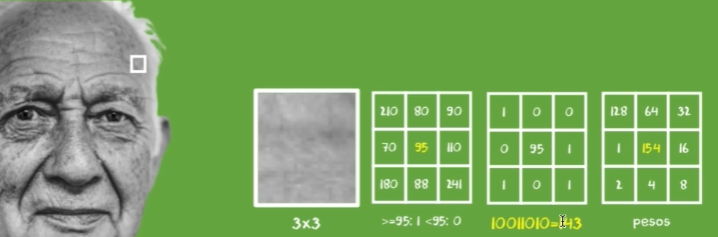

Esse processo cria um **padrão binário local para cada pixel central**, onde após isso, esses padrões são usados para construir um **histograma**. Este histograma representa a distribuição dos padrões binários na imagem inteira e seria a partir da **comparação entre histogramas** que o LBPH utiliza para comparar e classificar as faces.

Exemplo do histograma:
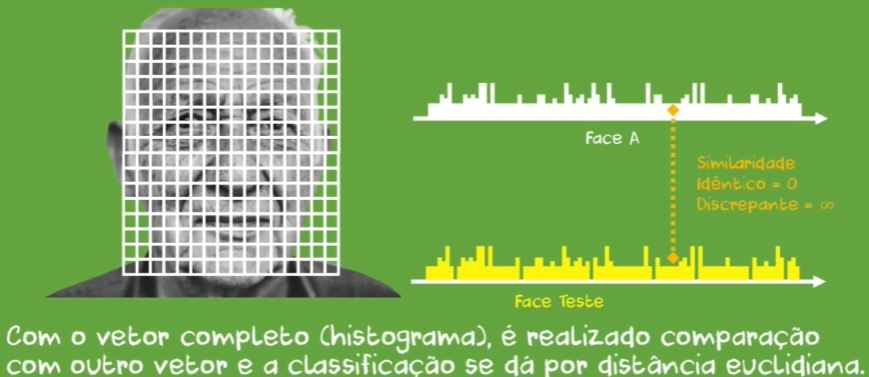

**Treinando o modelo**

In [15]:
lbph_model = cv2.face.LBPHFaceRecognizer.create()

lbph_model.train(X_train, y_train)

**Testando e avaliando o modelo**

É possível observar que pelo exemplo de retorno de uma das previsões, a distância é bem baixa. Este retorno (distância) pode ser usado como prática para ser definido se uma classe que foi prevista pelo modelo realmente pertence a esta classe específica na realidade.

In [16]:
test_model(lbph_model, X_test, y_test)

Exemplo de retorno do predict do primeiro item de teste:
Classe prevista: 41.0
Distância: 63.244862758272966
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.67      0.67      0.67         6
           2       0.67      1.00      0.80         6
           3       0.71      0.83      0.77         6
           4       1.00      1.00      1.00         2
           5       1.00      0.80      0.89         5
           6       1.00      0.67      0.80         6
           7       0.60      1.00      0.75         6
           8       0.67      0.67      0.67         6
           9       1.00      1.00      1.00         4
          10       0.86      1.00      0.92         6
          11       1.00      1.00      1.00         5
          12       0.83      0.83      0.83         6
          13       0.67      0.67      0.67         6
          14       1.00      1.00      1.00         6
          15       0.67   